## **Multiple traveling salesman problem with drones**


E-commerce and retail companies are seeking ways to cut delivery times and costs by exploring opportunities to use drones for making last mile delivery deliveries. To optimize the costs and delivery time nature inspired computing such as Ant colony optimization algorithm can be used and the problem formulated as Multiple traveling salesman problem (mTSP)


The Multiple Traveling Salesman Problem (mTSP) is defined as: In a given set of nodes, let there are $m$ salesmen / drones located at a single or multiple depot node(s). The remaining nodes (cities) that are to be visited are intermediate nodes. Then, the mTSP consists of finding tours for all $m$ salesmen / drones, who all start and end at the depot, such that each intermediate node is visited exactly once and the total cost of visiting all nodes is minimized.


<font color='red'><strong>Task</strong></font> : Using Ant colony optimization algorithm implement the **mTSP**

In [51]:
from matplotlib import colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import random
import warnings

matplotlib_colors = list(dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS).keys())

warnings.filterwarnings('ignore')

### ACO class for mTSP

In [52]:
import math

import matplotlib.pyplot as plt
import numpy as np
import random


class DronesACO(object):
    def __init__(self, num_city: int, cities_coords: list, num_drones: int, depots: list, n_ants: int = 50,
                 alpha: int = 1, beta: int = 5, rho: float = 0.1, n_iterations: int = 10, q: int = 10):
        """
        num_city : Number of cities
        n_ants : Number of ants
        cities_coords : Coordinates of the cities
        num_drones: number of drones
        alpha: Pheromone importance factor
        beta: Important factors of heuristic function
        rho: Pheromone evaporation factor
        depots: indices of deports in cities_coords list
        n_iterations: number of maximum algorithm iterations
        q: Constant coefficient
        """

        self.num_city = num_city
        self.num_drones = num_drones
        self.cities_coords = cities_coords
        self.n_ants = n_ants
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.depots = depots
        self.q = q

        self.distances = self.compute_dis_mat(num_city, self.cities_coords)
        self.paths_distances = None
        self.pheromones = np.zeros(self.distances.shape)
        self.n_iterations = n_iterations
        self.colony = [[0 for _ in range(num_city)] for _ in range(self.n_ants)]  # Generated ant colony

        self.Q = 1  # constant for calculating delta tau in pheromones updates
        self.n_iter = []
        self.fitness = []

    def roulette_selection(self, p: list) -> int:
        """
        Roulette selection
    
        Parameters
        - p : list of probabilities
    
        Returns
        - index of selection
        """
        x = np.random.rand()
        for i, t in enumerate(p):
            x -= t
            if x <= 0:
                break
        return i

    def _select_next(self, current: int, remaining: list) -> int:
        """
        Select the next city to visit based on pheromone trails and heuristic.
    
        Parameters:
        - current: The current city index
        - remaining: The list of cities that have not yet been visited
    
        Returns:
        - The index of next city to visit, randomly choosing with respect to the probabilities
        """
        p = []
        for i in remaining:
            p.append((self.pheromones[current][i] ** self.alpha) * (self._distance_heuristic(current, i) ** self.beta))
        p = np.array(p)
        p = p / p.sum()
        return remaining[self.roulette_selection(p)]

    def _distance_heuristic(self, i: int, j: int) -> float:
        """
        Calculate the heuristic value for moving from city i to city j.
    
        Parameters:
        - i: The current city.
        - j: The next city.
    
        Returns:
        - The heuristic value for moving from city i to city j.
        """
        return self.q / self.distances[i][j]

    def get_ants(self, num_city: int) -> None:
        """
        Generate an ant colony and saves each ant's path in self.colony.
        For each ant start at random city and make a path visiting all remaining cities
    
        Parameters:
        - num_city: Number of cities
        """
        # YOUR CODE HERE
        for i in range(self.n_ants):
            cities = list(range(num_city))
            start = np.random.choice(cities)
            cities.remove(start)
            path = [start]
            current = start
            while cities:
                next_city = self._select_next(current, cities)
                path.append(next_city)
                cities.remove(next_city)
                current = next_city
            self.colony[i] = path

    def compute_dis_mat(self, num_city: int, location: list) -> np.ndarray:
        """
        Calculate the distance matrix between cities.
        NOTE:
          1. Distance between depots i and j equals infinity
          2. Use euclidean distance
    
        Parameters:
          - num_city: number of cities
          - location: Coordinates of the cities
    
        Returns
          - distance between cities
        """
        dis_mat = np.zeros((num_city, num_city))
        for i in range(num_city):
            for j in range(num_city):
                if i == j:
                    dis_mat[i][j] = 0
                elif i in self.depots and j in self.depots:
                    # use big number to represent infinity
                    dis_mat[i][j] = 10000

                else:
                    dis_mat[i][j] = np.linalg.norm(location[i] - location[j])
        return dis_mat

    def compute_pathlen(self, target_path: list, dis_mat: list) -> int:
        """
        Compute the path length of a path
        NOTE: the distance from the origin to the origin is no longer inf, but 0
    
        Parameters:
          - target_path: path to calculate its length
          - dis_mat: Distance matrix
    
        Returns
          - length of a path
        """
        if target_path[0] not in self.depots:
            target_path = np.insert(target_path, 0, 0)
        if target_path[-1] not in self.depots:
            target_path = np.append(target_path, 0)
        length = 0
        for i in range(len(target_path) - 1):
            length += dis_mat[target_path[i]][target_path[i + 1]]
        return length

    def compute_paths(self, paths: list) -> list:
        """
        Calculate the path length of a group. For each ant / drone in the colony calculate the length
    
        Parameters
        - paths: paths for the colony
        """
        paths_distances = []
        for path in paths:
            paths_distances.append(self.compute_pathlen(path, self.distances))

        return paths_distances

    def update_pheromone(self) -> None:
        """
        Updates the pheromones matrix
        NOTE: update of pheromones defined as :
          pheromones = (1 - rho) * pheromones + delta_tau
    
        """
        self.paths_distances = self.compute_paths(self.colony)
        for i in range(self.num_city):
            for j in range(self.num_city):
                if i != j:
                    delta_tau = 0
                    for k in range(self.n_ants):
                        if j in self.colony[k]:
                            delta_tau += self.Q / self.paths_distances[k]
                    self.pheromones[i][j] = (1 - self.rho) * self.pheromones[i][j] + delta_tau

    def aco(self):
        """
        Full ant colony algorithm
        Returns:
            - shortest_path: The shortest path found by the algorithm.
            - shortest_distance: The distance of the shortest path.
        """
        best_lenth = math.inf
        best_path = None
        for epoch in range(self.n_iterations):
            # Generate a new ant colony
            self.get_ants(self.num_city)
            self.paths_distances = self.compute_paths(self.colony)

            # Take the optimal solution of the ant colony
            shortest_distance = min(self.paths_distances)
            tmp_path = self.colony[self.paths_distances.index(shortest_distance)]

            if shortest_distance < best_lenth:
                best_lenth = shortest_distance
                best_path = tmp_path

            # Update pheromone
            self.update_pheromone()

            # log result
            self.n_iter.append(epoch)
            self.fitness.append(best_lenth)
            print(f"Iteration {epoch:3}: Fitness \t{best_lenth:.3f}")
        return best_lenth, best_path

    def run(self):
        """
        Returns:
            - shortest path coordinates: The shortest path found by the algorithm.
            - shortest_distance: The distance of the shortest path.
        """
        best_length, best_path = self.aco()
        return self.cities_coords[best_path], best_length

### Testing Implementation

In [53]:
num_drones = 15
n_cities = 200
n_iterations = 50
np.random.seed(42)


def cities_coordinates(n_cities: int = 1) -> list:
    """
    Initialization coordinates (the first point is the starting point of the base, and the coordinates of the starting point are 0,0)
    """
    coordinates = [[0, 0]]
    for i in range(n_cities - 1):
        while True:
            x = np.random.randint(-250, 250)
            y = np.random.randint(-250, 250)
            if x != 0 or y != 0:
                break
        coordinates.append([x, y])
    return np.array(coordinates)


data = cities_coordinates(n_cities=n_cities)

# Key: If there are N drones, then add N-1 'points` (the coordinates are the starting point), and the distance between these points is inf
# For the sake of simplicity all the other depots are located at [0,0]
for d in range(num_drones - 1):
    data = np.vstack([data, data[0]])
    n_cities += 1  # Increase deception city

depots_idx = [0]
for d in range(1, num_drones):
    depots_idx.append(n_cities - d)

aco = DronesACO(num_city=data.shape[0], cities_coords=data.copy(),
                num_drones=num_drones, depots=depots_idx,
                n_iterations=n_iterations
                )
Best_path, best_fitness = aco.run()
tot_iterations = aco.n_iter
best_record = aco.fitness

print(f"Best Path Length: {best_fitness:.3f}")

Iteration   0: Fitness 	178463.694
Iteration   1: Fitness 	9603.427
Iteration   2: Fitness 	9603.427
Iteration   3: Fitness 	9193.784
Iteration   4: Fitness 	9193.784
Iteration   5: Fitness 	9193.784
Iteration   6: Fitness 	9193.784
Iteration   7: Fitness 	9193.784
Iteration   8: Fitness 	9193.784
Iteration   9: Fitness 	9193.784
Iteration  10: Fitness 	9193.784
Iteration  11: Fitness 	8752.314
Iteration  12: Fitness 	8752.314
Iteration  13: Fitness 	8752.314
Iteration  14: Fitness 	8752.314
Iteration  15: Fitness 	8752.314
Iteration  16: Fitness 	8752.314
Iteration  17: Fitness 	8752.314
Iteration  18: Fitness 	8752.314
Iteration  19: Fitness 	8752.314
Iteration  20: Fitness 	8752.314
Iteration  21: Fitness 	8752.314
Iteration  22: Fitness 	8752.314
Iteration  23: Fitness 	8752.314
Iteration  24: Fitness 	8752.314
Iteration  25: Fitness 	8752.314
Iteration  26: Fitness 	8752.314
Iteration  27: Fitness 	8752.314
Iteration  28: Fitness 	8752.314
Iteration  29: Fitness 	8752.314
Iteratio

### Visualizing results

In [57]:



def find_indices(list_to_check, item_to_find):
    indices = []
    for idx, value in enumerate(list_to_check):
        if np.array_equal(value, item_to_find):
            indices.append(idx)
    return indices


def plot_results(Best_path, iterations, best_record):
    random.shuffle(matplotlib_colors)
    if not np.array_equal(Best_path[0], [0, 0]):
        Best_path = np.vstack([[0, 0], Best_path])
    if not np.array_equal(Best_path[-1], [0, 0]):
        Best_path = np.vstack([Best_path, [0, 0]])
        # print(Best_path)

    found_start_points_indices = find_indices(Best_path, [0, 0])
    result_paths = []

    for j in range(len(found_start_points_indices) - 1):
        from_index = found_start_points_indices[j]
        end_index = found_start_points_indices[j + 1]
        path = []
        for k in range(from_index, end_index + 1):
            path.append(Best_path[k])
        path = np.array(path)
        result_paths.append(path)

    fig, axs = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(15, 7))
    axs[0].scatter(Best_path[:, 0], Best_path[:, 1])

    for ix, path in enumerate(result_paths):
        axs[0].plot(path[:, 0], path[:, 1], color=matplotlib_colors[ix], alpha=0.8, label=f'drone {ix + 1}')

    axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
    axs[0].plot([0], [0], marker="*", markersize=20, color="red")

    axs[0].set_title("Searched Best Solution")

    axs[1].plot(iterations, best_record, label='Fitness')
    axs[1].set_title("Convergence Curve")
    axs[1].legend(loc='best')
    axs[1].set_ylabel('Fitness')
    axs[1].set_xlabel('Iteration Number')
    plt.show()

# plot_results(Best_path, iterations, best_record)

## Ploting the results

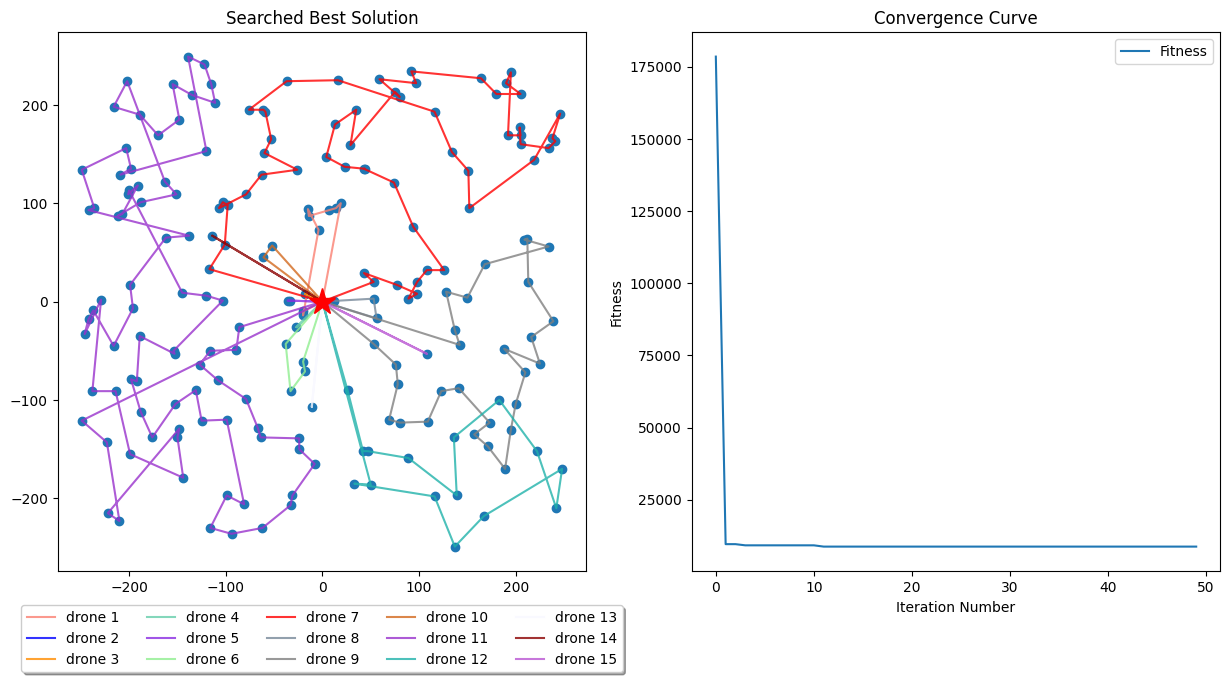

In [58]:
plot_results(Best_path, tot_iterations, best_record)

In [56]:
print(np.sqrt(250 ** 2 + 250 ** 2))

353.5533905932738
